Tutorial: absolutely minimal BIOCHROSE workflow
===============================================

In this tiny tutorial, we will perform all the necessary steps to set up a posterior distribution and a Gibbs sampler which is then used to sample from it. After, we discuss some elementary analysis of the samples.
The data we consider here were generated from two small, highly artificial structures: a chain of $11$ beads assuming either a hairpin-shaped or an S-shaped conformation.

Setting up a posterior distribution and sampling from it
--------------------------------------------------------

All information required for infering chromatin structures using BIOCHROSE is contained in `.ini`-like configuration files, the content of which is described elsewhere. As a first step to launching a toy BIOCHROSE simulation, we parse a configuration file:

In [1]:
from ensemble_hic.setup_functions import parse_config_file
settings = parse_config_file('doc_config.cfg')

`settings` now is a dictionary of dictionary, in which the keys of the first layer are the section titles, that is,

In [2]:
print settings.keys()

['weights_hmc', 'data_filtering', 'sphere_prior', 'nonbonded_prior', 'forward_model', 'norm_prior', 'general', 'replica', 'initial_state', 'backbone_prior', 'structures_hmc']


and the keys of the second layer the parameters set in a single section, e.g.,

In [3]:
print settings['general'].keys()

['error_model', 'data_file', 'variables', 'output_folder', 'n_beads', 'n_structures']


All values are parsed as strings, so at the moment, some care has to be taken; for example, `boolean` values must be either `'True'` or `'False'` with exactly that capitalization.
We next create the central object in ISD, namely the posterior distribution, according to the settings we just loaded:

In [4]:
from ensemble_hic.setup_functions import make_posterior
posterior = make_posterior(settings)

The `posterior` object now holds all likelihoods and priors we specified via the configuration file. Next, we create an initial state for the Markov chain we are going to construct later:

In [5]:
from ensemble_hic.setup_functions import setup_initial_state
initial_state = setup_initial_state(settings['initial_state'], posterior)

The initial state holds initial values for the variables of the posterior distribution in its `variables` property:

In [6]:
type(initial_state.variables['structures'])
print initial_state.variables['structures'].shape
print initial_state.variables['norm']

(66,)
100


The variable `structures` is a 1D NumPy array of length `n_structures x n_beads x 3` and variable `norm`, denoting the the scaling factor $\alpha$, is some `float`.

The next step is now to set up the samplers for each variable:

In [7]:
from ensemble_hic.setup_functions import make_subsamplers
subsamplers = make_subsamplers(posterior, initial_state.variables, settings['structures_hmc'])
print subsamplers

{'structures': <binf.samplers.hmc.HMCSampler object at 0x7efbffbd6590>, 'norm': <ensemble_hic.npsamplers.NormGammaSampler object at 0x7efbffbd65d0>}


We have a Hybrid Monte Carlo sampler for the bead coordinates in the `structures` variable and an object which wraps a NumPy function to sample from a Gamma distribution which is the conditional distribution of the scaling factor.

Finally, we need to set up the Gibbs sampler:

In [8]:
from binf.samplers.gibbs import GibbsSampler
sampler = GibbsSampler(posterior, initial_state, subsamplers)

Now we're ready to draw samples from the posterior distribution (might take a while, $\sim 3$ minutes on my laptop):

In [9]:
from copy import deepcopy
n_samples = 10000
samples = []
for i in range(n_samples):
    samples.append(deepcopy(sampler.sample()))
    if i % 500 == 0:
        print '{}/{} samples drawn'.format(i, n_samples)
    

0/10000 samples drawn
500/10000 samples drawn
1000/10000 samples drawn
1500/10000 samples drawn
2000/10000 samples drawn
2500/10000 samples drawn
3000/10000 samples drawn
3500/10000 samples drawn
4000/10000 samples drawn
4500/10000 samples drawn
5000/10000 samples drawn
5500/10000 samples drawn
6000/10000 samples drawn
6500/10000 samples drawn
7000/10000 samples drawn
7500/10000 samples drawn
8000/10000 samples drawn
8500/10000 samples drawn
9000/10000 samples drawn
9500/10000 samples drawn


Basic analysis
==============

Let's check the trace of the negative log-posterior to get an idea whether the simulation converged:

<IPython.core.display.Javascript object>


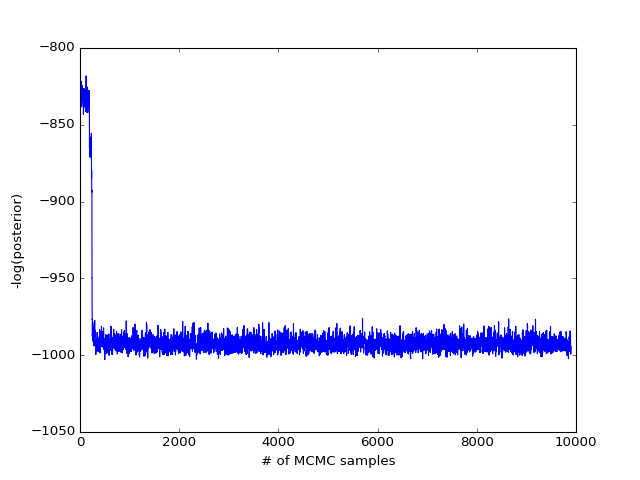

In [10]:
%matplotlib nbagg
import matplotlib.pyplot as plt
energies = map(lambda x: -posterior.log_prob(**x.variables), samples)
fig, ax = plt.subplots()
ax.plot(energies[100:])
ax.set_xlabel('# of MCMC samples')
ax.set_ylabel('-log(posterior)')
plt.show()

You should see the negative logarithm of the posterior probability level off and fluctuate around some fixed average. The number of MCMC samples at which this happens should be discarded as a burn-in period, in which the Markov chain forgets its initial state. It is important to remember that in a production run with actual data, you should absolutely use Replica Exchange to speed up convergence - already in this example, it can easily take a few thousand MCMC samples to reach equilibrium. Let's take a look at the sampled values for the scaling factor $\alpha$:

<IPython.core.display.Javascript object>


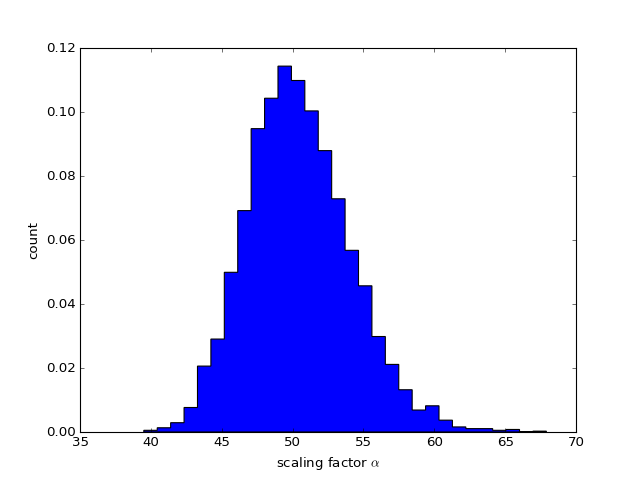

In [19]:
burnin = 6000
fig, ax = plt.subplots()
ax.hist([x.variables['norm'] for x in samples[burnin:]], bins=30, histtype='stepfilled', normed=True)
ax.set_xlabel(r'scaling factor $\alpha$')
ax.set_ylabel('count')
plt.show()

The histogram should be centered around a value of $\sim 50$. To find out whether we correctly reproduce the contact data, let's look at a scatter plot of back-calculated ("mock") vs experimental data:

<IPython.core.display.Javascript object>


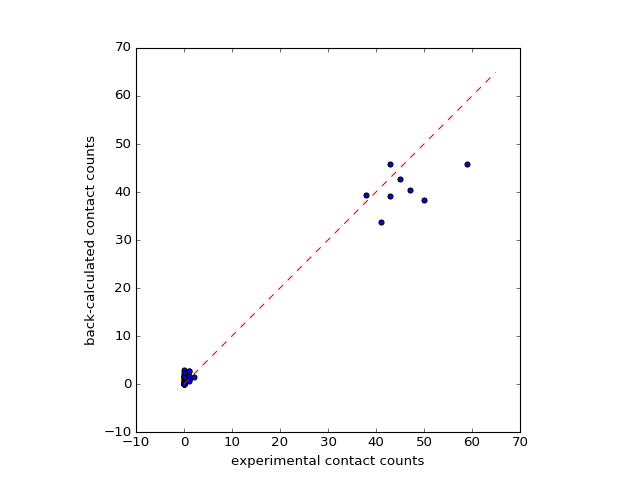

In [12]:
fwm = posterior.likelihoods['ensemble_contacts'].forward_model
exp_data = fwm.data_points[:,2]
mock_data = fwm(**samples[-1].variables)
fig, ax = plt.subplots()
ax.scatter(exp_data, mock_data)
ax.set_xlabel('experimental contact counts')
ax.set_ylabel('back-calculated contact counts')
ax.plot((0, 1.1 * max(exp_data)), (0, 1.1 * max(exp_data)), ls='--', c='r')
ax.set_aspect('equal')
plt.show()

You should find a bunch of points with zero contact counts in both the models and the actual data and a cloud of points at around (50,50). The discrepancies are likely due to the highly artificial structures from which the simulated data were generated. How do the contact frequency matrices compare?

<IPython.core.display.Javascript object>


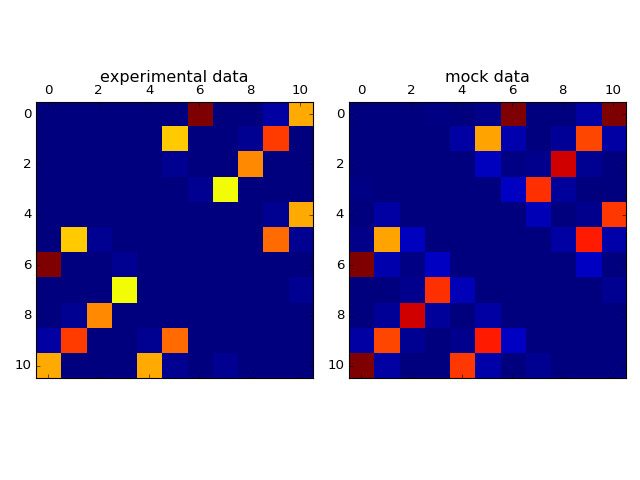

In [13]:
import numpy as np
n_beads = int(settings['general']['n_beads'])
b1 = fwm.data_points[:,0]
b2 = fwm.data_points[:,1]
exp_m = np.zeros((n_beads, n_beads))
exp_m[b1, b2] = exp_data
exp_m[b2, b1] = exp_data
mock_m = np.zeros((n_beads, n_beads))
mock_m[b1, b2] = mock_data
mock_m[b2, b1] = mock_data
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.matshow(exp_m)
ax1.set_title('experimental data')
ax2.matshow(mock_m)
ax2.set_title('mock data')
fig.tight_layout()
plt.show()

Not too bad, I hope! Note that the main, 1st and 2nd diagonal is missing, because these contacts were not taken into account. 
We can also take a look at the back-calculated contact matrices of the single states. To this end, we generate a posterior object for $n=1$ states and feed its forward model the coordinates of the single states of the $n=2$ model :

<IPython.core.display.Javascript object>


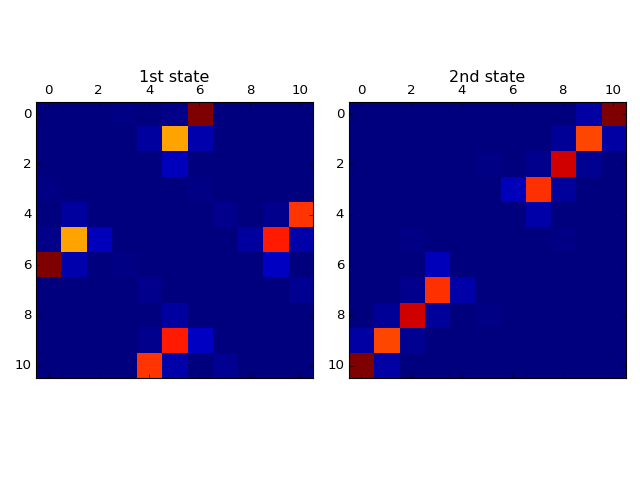

In [14]:
settings['general']['n_structures'] = '1'
p_n1 = make_posterior(settings)
fwm = p_n1.likelihoods['ensemble_contacts'].forward_model
md1 = fwm(structures=samples[-1].variables['structures'][:3*n_beads], norm=1.0)
md2 = fwm(structures=samples[-1].variables['structures'][3*n_beads:], norm=1.0)
fig, (ax1, ax2) = plt.subplots(1,2)
m1 = np.zeros((n_beads, n_beads))
m1[b1,b2] = md1
m1[b2,b1] = md1
m2 = np.zeros((n_beads, n_beads))
m2[b1,b2] = md2
m2[b2,b1] = md2
ax1.matshow(m1)
ax1.set_title('1st state')
ax2.matshow(m2)
ax2.set_title('2nd state')
fig.tight_layout()
plt.show()

If the Markov chain reached its equibrium, you should see that one state assumes the hairpin conformation (one diagonal in the matrix) and the other the "S" conformation (two diagonals). To visualize this, let's write a PDB file of our multi-state model:

In [15]:
from ensemble_hic.analysis_functions import write_ensemble
write_ensemble(samples[-1].variables['structures'].reshape(-1,n_beads,3), '/tmp/ensemble.pdb')

This PDB file will be a multi-model file with $n=2$ models. It can be opened with, e.g., VMD or PyMol. Note that you don't neccessarily get 2D structures: both the hairpin and the "S" shape have, embedded in 3D space, different conformations which give rise to the same contact data.
We can also create a VMD script, which will load the PDB file and choose a convenient graphical representation as beads:

In [16]:
from ensemble_hic.analysis_functions import write_VMD_script
bead_radii = posterior.priors['nonbonded_prior'].forcefield.bead_radii
write_VMD_script('/tmp/ensemble.pdb', bead_radii, '/tmp/show_ensemble.rc')

This can now be run with the command `vmd -e /tmp/show_ensemble.rc`.